#### replicate the minimum torsion method in:
#### Meucci, Attilio and Santangelo, Alberto and Deguest, Romain, Risk Budgeting and Diversification Based on Optimized Uncorrelated Factors (November 10, 2015). Available at SSRN: https://ssrn.com/abstract=2276632 or http://dx.doi.org/10.2139/ssrn.2276632

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
# data cleaning
data = pd.read_csv("./return_data.csv")
data["index"] = pd.to_datetime(data["index"], format="%Y-%m-%d")
data = data.set_index("index")

In [31]:
# extract correlation matrix
sigma = data.cov()
cor = data.corr()
std = np.zeros((data.shape[1],data.shape[1]))
np.fill_diagonal(std, data.std())

# check
print(np.any((sigma.values - (std.T @ cor @ std).values) > 1e-6))

False


In [32]:
# eigen decomposition
eg_val, eg_vec = np.linalg.eig(cor)
value = np.zeros((data.shape[1],data.shape[1]))
np.fill_diagonal(value, np.sqrt(eg_val))
result = eg_vec @ np.multiply(value, value) @ eg_vec.T

# check
print(np.any((result - cor.values) > 1e-6))

c = eg_vec @ value @ eg_vec.T

False


In [33]:
# recursive algorithm
def mt(c, threshold, loop_num:int):
    d = np.eye(c.shape[1])
    pi = 0
    for i in range(loop_num):
        u = (d @ (c*c) @ d)**0.5
        inv_u = np.linalg.inv(u)
        if np.isnan(inv_u).sum() > 0:
            break
        q = inv_u.T @ d @ c
        qc = np.zeros((c.shape[0], c.shape[1]))
        np.fill_diagonal(qc, np.diag(q.T @ c))
        d = qc
        if np.all((d @ q - pi) < threshold):
            break
        else:
            pi = d @ q
    return pi

In [34]:
# check
C_test = np.array([[1, 0.5, 0.3], [0.5, 1, 0.1], [0.3, 0.1, 1]])
eg_val_test, eg_vec_test = np.linalg.eig(C_test)
value_test = np.zeros((C_test.shape[1],C_test.shape[1]))
np.fill_diagonal(value_test, np.sqrt(eg_val_test))

c_test = eg_vec_test @ value_test @ eg_vec_test.T

result_test = mt(c_test, 1e-6, int(1e9))
expected_test = np.array([
        [0.9535, -0.0016, -0.0026],
        [0.0017, 0.9661, -0.0001],
        [0.0027, 0.0001, 0.9886]])

np.linalg.norm(result_test - expected_test, 'fro')

0.0007428807319840459

In [35]:
std_diag = np.zeros((data.shape[1],data.shape[1]))
np.fill_diagonal(std_diag, np.diag(std))
pi_data = mt(c, 1e-6, int(1e9))
t_data =  std_diag @ pi_data @ np.linalg.inv(c) @ np.linalg.inv(std_diag)
t_data

array([[ 1.11177241e+00, -1.53122622e-02, -6.67586374e-02, ...,
        -1.18981805e-02, -8.64625823e-03, -4.73946760e-03],
       [-1.38521652e-02,  1.12334884e+00,  8.33219901e-03, ...,
        -6.87814713e-03,  4.05730756e-04, -1.77076288e-02],
       [-5.37105760e-02,  7.41026387e-03,  1.18631103e+00, ...,
        -1.47305108e-03, -7.52700573e-03,  5.30182875e-03],
       ...,
       [-3.31530094e-02, -2.11853459e-02, -5.10161715e-03, ...,
         1.18350980e+00, -3.83626621e-02,  2.90920060e-02],
       [-1.53149833e-02,  7.94415938e-04, -1.65713628e-02, ...,
        -2.43867911e-02,  1.19370289e+00, -1.10337963e-02],
       [-1.15395055e-02, -4.76584313e-02,  1.60446775e-02, ...,
         2.54207819e-02, -1.51668111e-02,  1.08951092e+00]])

#### Backtest and comparison - naive risk parity vs. min-tor

In [83]:
window = 300
s = data.shape[1]
naive_par = []
min_tor = []
for i in range(window,900):
    data_rolling = data.copy().iloc[i-window:i,:]
    sigma = data_rolling.cov()
    cor = data_rolling.corr()
    std = np.zeros((s,s))
    np.fill_diagonal(std, data_rolling.std())
    
    eg_val, eg_vec = np.linalg.eig(cor)
    value = np.zeros((s,s))
    np.fill_diagonal(value, np.sqrt(eg_val))
    result = eg_vec @ np.multiply(value, value) @ eg_vec.T
    c = eg_vec @ value @ eg_vec.T

    std_diag = np.zeros((s,s))
    np.fill_diagonal(std_diag, np.diag(std))
    pi_data = mt(c, 1e-6, int(1e9))
    t_data =  std_diag @ pi_data @ np.linalg.inv(c) @ np.linalg.inv(std_diag)
    
    w_np = np.linalg.inv(sigma) @ np.ones(s) / ((np.ones(s).T @ np.linalg.inv(sigma) @ np.ones(s)))
    w_mt = np.linalg.inv(t_data) @ np.ones(s) / (np.ones(s).T @ np.linalg.inv(t_data) @ np.ones(s))
    data_next = data.copy().iloc[i+1,:]
    naive_par.append(w_np.T @ data_next * 100)
    min_tor.append(w_mt.T @ data_next * 100)

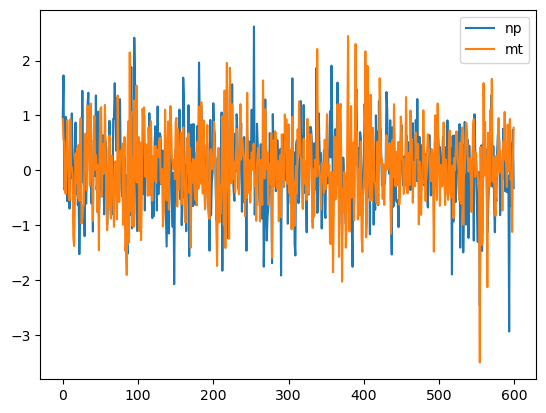

0.030052880612288804 0.05333083939272144
0.7346738236383668 0.7097021751246156


In [84]:
x = range(600)
plt.plot(x, naive_par, label = "np") 
plt.plot(x, min_tor, label = "mt") 
plt.legend() 
plt.show()

print(np.array(naive_par).mean(), np.array(min_tor).mean())
print(np.array(naive_par).std(), np.array(min_tor).std())